In [1]:
from drain.model import Drain,Node,LogCluster
from drain.optimizer import Optimizer
from drain.plotter import createPlot
from drain.partition import Partition
from utils.generate_data import *
from lstm.trainer import Model,train
from lstm.predictor import fast_predict
from torch import nn,optim
from torch.utils.data import  DataLoader

import pandas as pd
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 32
batch_size = 2048
input_size = 1
window_size = 10
num_layers = 2
hidden_size = 64

In [3]:
logPath = 'D:\\毕业设计\\loghub\\HDFS_1\\HDFS.log'
parsed_result = '.\\data\\parser\\log_item_to_label.csv'
cluster_result = '.\\data\\parser\\'
# partition
partition_output = '.\\data\\lstm\\dataset\\'
instance_file = 'instance.csv'
label_file = '.\\data\\partition\\anormaly_label.csv'
normal_output = 'normal.csv'
abnormal_output = 'abnormal.csv'
lstm_dataset = '.\\data\\lstm\\dataset\\'

In [4]:
def parse_log():

    rex = ['blk_(|-)[0-9]+', '(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)']
    removeCol = [0,1,2]
    myParser = Drain(rex=rex,removeCol=removeCol,st=0.4)
    myParser.fit(isReconstruct=True,inputFile=logPath,outputFile=parsed_result)

    myParser.save(savePath=cluster_result)

'''
partition phase
'''
def partition():

    partition = Partition(outputFileDir=partition_output,log_item_to_event_id_file=parsed_result,instances_file_path=instance_file,label_file_path=label_file,normal_output=normal_output,abnormal_output=abnormal_output)
    partition.partition_by_file()
    partition.map_log_seq_to_label()

    split_data(input_dir=partition_output,output_dir=lstm_dataset)

In [5]:
model_dir = 'model'
version = 'v0.3'
model_name = 'total_version={}'.format(version)

model = Model(input_size, hidden_size, num_layers, num_classes).to(device)

if os.path.exists(model_dir + '/' + model_name + '.pt'):
    model.load_state_dict(torch.load(model_dir + '/' + model_name + '.pt'))

In [6]:
criterion = nn.CrossEntropyLoss(ignore_index=31)
optimizer = optim.Adam(model.parameters())
model.train()
train_dataset = generate_train_data(lstm_dataset + 'train.csv')
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

train(model, dataloader, criterion, optimizer, current_epoch=100, num_epochs=200)

loading data: 100%|█████████████████████████████████████████████████████████████| 5582/5582 [00:00<00:00, 22173.86it/s]


Number of sessions(.\data\lstm\dataset\train.csv): 5582
Number of seqs(.\data\lstm\dataset\train.csv): 114329
Epoch [101/300], train_loss: 0.4778
Epoch [102/300], train_loss: 0.4735
Epoch [103/300], train_loss: 0.4723
Epoch [104/300], train_loss: 0.4708
Epoch [105/300], train_loss: 0.4697
Epoch [106/300], train_loss: 0.4683
Epoch [107/300], train_loss: 0.4672
Epoch [108/300], train_loss: 0.4657
Epoch [109/300], train_loss: 0.4645
Epoch [110/300], train_loss: 0.4635
Epoch [111/300], train_loss: 0.4628
Epoch [112/300], train_loss: 0.4615
Epoch [113/300], train_loss: 0.4609
Epoch [114/300], train_loss: 0.4599
Epoch [115/300], train_loss: 0.4594
Epoch [116/300], train_loss: 0.4586
Epoch [117/300], train_loss: 0.4577
Epoch [118/300], train_loss: 0.4570
Epoch [119/300], train_loss: 0.4562
Epoch [120/300], train_loss: 0.4557
Epoch [121/300], train_loss: 0.4555
Epoch [122/300], train_loss: 0.4547
Epoch [123/300], train_loss: 0.4539
Epoch [124/300], train_loss: 0.4536
Epoch [125/300], train_los

KeyboardInterrupt: 

In [8]:
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
torch.save(model.state_dict(), model_dir + '/' + model_name + '.pt')
print('Finished Training')

Finished Training


In [6]:
model.eval()
batch_size = 20000
test_normal_session, test_normal_dataset, test_normal_seq, test_normal_label = generate_test_data(
    lstm_dataset + '/normal.csv', window_size)
normal_dataloader = DataLoader(test_normal_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_abnormal_session, test_abnormal_dataset, test_abnormal_seq, test_abnormal_label = generate_test_data(
    lstm_dataset + '/abnormal.csv', window_size)
abnormal_dataloader = DataLoader(test_abnormal_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

test_normal_result, test_abnormal_result = fast_predict(model, normal_dataloader, abnormal_dataloader,
                                                        test_normal_session, test_abnormal_session,
                                                        10, window_size)

.\data\lstm\dataset\/normal.csv: 100%|████████████████████████████████████████| 14190/14190 [00:00<00:00, 19216.43it/s]


Number of sessions(.\data\lstm\dataset\/normal.csv): 14190
Number of seqs(.\data\lstm\dataset\/normal.csv): 269855


.\data\lstm\dataset\/abnormal.csv: 100%|████████████████████████████████████████| 4121/4121 [00:00<00:00, 21312.25it/s]
normal: 0it [00:00, ?it/s]

Number of sessions(.\data\lstm\dataset\/abnormal.csv): 4121
Number of seqs(.\data\lstm\dataset\/abnormal.csv): 88562


normal: 14it [01:03,  4.56s/it]
abnormal: 5it [00:23,  4.66s/it]

elapsed_time: 87.249s
false positive (FP): 1128, false negative (FN): 181, Precision: 77.743%, Recall: 95.608%, F1-measure: 85.755%
Finished Predicting


In [8]:
test_normal_result, test_abnormal_result = fast_predict(model, normal_dataloader, abnormal_dataloader,
                                                        test_normal_session, test_abnormal_session,
                                                        10, window_size,ts=0.00005)

normal: 14it [01:00,  4.35s/it]
abnormal: 5it [00:15,  3.03s/it]

elapsed_time: 76.180s
false positive (FP): 786, false negative (FN): 430, Precision: 82.444%, Recall: 89.566%, F1-measure: 85.857%
Finished Predicting


In [6]:
from lstm.wf_constructor import workflow_constructor,draw_wf

In [7]:
wf = workflow_constructor(model,input_size=1)

In [8]:
wf.generate_seq([1],1,3)

(tensor([[1., 1.]]),
 tensor([22, 20, 10,  7,  6,  4,  5,  3,  2,  1]),
 tensor([-11.1364,   6.5688,   5.8336,   5.4769,   1.3936,   4.5288,   0.2500,
           0.1636,  -3.3475,  -3.9446,  -1.7440,  -5.8533, -10.9219,  -6.8697,
         -10.7340, -10.9836, -11.2700, -10.9649, -10.9487, -11.4953,  -2.1475,
         -11.2003,  -2.6860, -10.8976, -10.6818, -10.6616, -10.8612, -10.4325,
         -10.8212, -11.2100,  -4.1044, -10.7594], grad_fn=<ViewBackward>))

In [9]:
wf.workflow_construction([0],{30})

当前序列为: [0] 下一个可能出现event为: [2, 1]
判断分支情况 [2, 1]
发现不同的分支 [[2, 1]]
并发执行的分支 [2, 1]
发现循环 [1]
当前序列为: [2, 1] 下一个可能出现event为: [3, 4, 5]
判断分支情况 [3, 4, 5]
发现不同的分支 [[3, 4, 5]]
并发执行的分支 [3, 4, 5]
发现循环 [3]
发现循环 [4]
发现循环 [5]
当前序列为: [3, 4, 5] 下一个可能出现event为: [10, 11, 20, 22, 30]
判断分支情况 [10, 11, 20, 22, 30]
发现不同的分支 [[10, 11, 20, 22]]
并发执行的分支 [10, 11, 20, 22]
发现循环 [10]
发现循环 [11]
发现循环 [20]
发现循环 [22]
当前序列为: [10, 11, 20, 22] 下一个可能出现event为: [13, 30]
判断分支情况 [13, 30]
发现不同的分支 [[13]]
当前序列为: [13] 下一个可能出现event为: [30]
到达终止位置,结束 {30}


[0]

0 1 (0, 2)
0 2 (-0.5, 3)
1 2 (0.5, 3)
0 1 (0, 4)
0 1 (0, 5)
0 3 (-1, 6)
1 3 (0, 6)
2 3 (1, 6)
0 1 (0, 7)
0 1 (0, 8)
0 4 (-1.5, 9)
1 4 (-0.5, 9)
2 4 (0.5, 9)
3 4 (1.5, 9)
1 1 (0, 10)
0 1 (0, 11)
0 1 (0, 12)


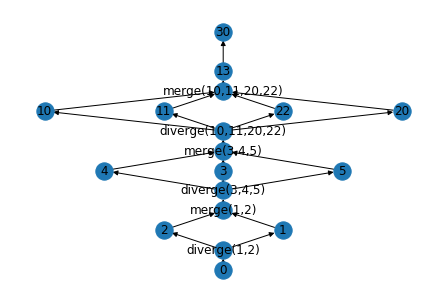

In [10]:
draw_wf(wf)

In [1]:
def split_data(file_dir):
    count = 0
    with open(file_dir+'/normal','r') as f:
        for i in f:
            count+=1
    print(4855/count)
    return 
    data_set = random_split(range(count),[4855,count-4855])
    f1 = open(file_dir+'/hdfs_test_normal','w')
    f2 = open(file_dir+'/hdfs_train','w')
    with open(file_dir+'/normal','r') as f:
        lines = f.readlines()
        for i in data_set[0]:
            f2.write(lines[i])
        for i in data_set[1]:
            f1.write(lines[i])
    f1.close()
    f2.close()

In [13]:
count = 0
with open('./data/lstm/dataset/normal.csv','r') as f:
    for i in f:
        count+=1
print(4855/count)

0.0087850724338722


In [14]:
count

552642

In [12]:
count

552642